In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Objective

The dataset I chose to use for this project comes from the UCI Machine Learning Respository. The UCI Machine Learning Repository is an open source database, created by the University of California in Irvine, where anyone can download data for machine learning or statistical analysis. The dataset has 10 columns; 9 numerical attributes and one outcome variable that classifies a particular type of event that occured. The goal of this project is to find the best classifier model for accurately predicting an event from this type of data in general. The data is based on real, past events so it is my goal to use it to develop a model that can accurately classify an event that is occuring based on data it is gathering from sensors on the ship during space-flight. A model like this could be used to predict and warn the engineers when conditions start to resemble those that lead to certain events that could be catastrophic. One of the things about this dataset that caught my attention is that the data comes from the NASA Space Shuttle (not sure which one). An engineer at NASA that is sending humans into space on giant missiles doesn't have much room for error so I hope to achieve an accuracy of at least 99%.

# Collection

In [3]:
col_names = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','label']
shuttle_train = pd.read_csv('shuttle.trn',delimiter=' ',names=col_names)
shuttle_test = pd.read_csv('shuttle.tst',delimiter=' ',names=col_names)

In [4]:
shuttle_train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,label
0,50,21,77,0,28,0,27,48,22,2
1,55,0,92,0,0,26,36,92,56,4
2,53,0,82,0,52,-5,29,30,2,1
3,37,0,76,0,28,18,40,48,8,1
4,37,0,79,0,34,-26,43,46,2,1


# Preprocessing

In [5]:
shuttle_train.isnull().sum()

x1       0
x2       0
x3       0
x4       0
x5       0
x6       0
x7       0
x8       0
x9       0
label    0
dtype: int64

In [6]:
shuttle_test.isnull().sum()

x1       0
x2       0
x3       0
x4       0
x5       0
x6       0
x7       0
x8       0
x9       0
label    0
dtype: int64

Neither our training or test set has any null values so that saves me a preprocessing step.

The dataset was provided already divided into training and test sets so instead of using the sci-kit learn function to split it we will just use pandas to pull the necessary columns. The first column in the dataset is the time, however, this dataset is already randomized so time is irrelevant so to prevent it from impacting my models I will not include it.

In [31]:
X_train = shuttle_train.iloc[:,1:-1]
X_test = shuttle_test.iloc[:,1:-1]
y_train = shuttle_train.iloc[:,-1]
y_test = shuttle_test.iloc[:,-1]

In [44]:
X_train.head()

,x2,x3,x4,x5,x6,x7,x8,x9
0,21,77,0,28,0,27,48,22
1,0,92,0,0,26,36,92,56
2,0,82,0,52,-5,29,30,2
3,0,76,0,28,18,40,48,8
4,0,79,0,34,-26,43,46,2


In the next step I scale the exploratory variables for my models that require data on the same scale.

In [32]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

# Model analysis

My first model is a logistic regression. I created models for both one-vs-all and multinomial logistic classifiers. Both have a high accuracy - the multinomial classifier being higher - but neither achieve the 99% accuracy we hope for.

In [33]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0,random_state=1,solver='lbfgs',multi_class='ovr')
lr.fit(X_train_std,y_train)
print(lr.score(X_test_std,y_test))

0.9354482758620689


In [34]:
from sklearn.linear_model import LogisticRegression
lr2 = LogisticRegression(C=100.0,random_state=1,solver='lbfgs',multi_class='multinomial')
lr2.fit(X_train_std,y_train)
print(lr2.score(X_test_std,y_test))

0.9664137931034483


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The next model I made was a support vector machine. It performed even better on predicting the test set but still did not achieve our goal. 

In [35]:
from sklearn.svm import SVC
svm = SVC(kernel='linear',C=1.0,random_state=1)
svm.fit(X_train_std,y_train)
print(svm.score(X_test_std,y_test))

0.9790344827586207


The next model is decision tree. For this model I used the non-standardized data. As you can see, this achieved the level of accuracy I desired for this problem. From the plot of the tree, we can see that the decision tree converges at a depth of 9. Decreasing the max_depth affects the accuracy negatively.

In [36]:
from sklearn.tree import DecisionTreeClassifier
treefit = DecisionTreeClassifier(criterion='gini',max_depth=10,random_state=1)
treefit.fit(X_train,y_train)
treefit.score(X_test,y_test)

0.999448275862069

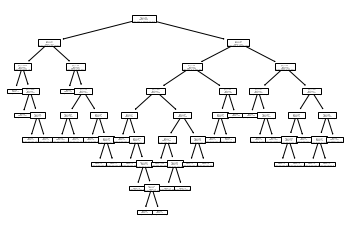

In [37]:
from sklearn import tree
tree.plot_tree(treefit)
plt.show()

The first tree is modeled on the full training set without any dimenstionality reduction. We will compare it to models with fewer components and choose the simplest model that achieves the desired accuracy.

Below is a loop that iterates through different numbers of components in the Principal Component Analysis. Each tuple in the list contains the number of components, the depth of the tree and the accuracy of the model. We can see that none of the models perform well with reduced dimensionality.

In [39]:
from sklearn.decomposition import PCA
tree_list=[]
for i in range(2,8):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train_std)
    X_test_pca = pca.fit_transform(X_test_std)
    a_tree = DecisionTreeClassifier(criterion='gini',max_depth=30,random_state=1)
    a_tree.fit(X_train_pca,y_train)
    tree_list.append((i,a_tree.get_depth(),a_tree.score(X_test_pca,y_test)))
print(tree_list)

[(2, 24, 0.6273103448275862), (3, 24, 0.640896551724138), (4, 19, 0.6798620689655173), (5, 18, 0.7399310344827587), (6, 17, 0.6892413793103448), (7, 16, 0.6916551724137932)]


Finally we will see how an ensemble of decision trees performs. As you can see this still achieves the level of accuracy I want; in fact, its probability is 0.0002 higher. Now we have to chose the trade-off between computation time and accuracy. As I mentioned before, I imagine the margin for error on a space shuttle is extremely small so that slight difference in accuracy may be considerable in this case and therefore I may want to use the more accurate model. On the other hand, the purpose for this classifier would be to foresee potential hazards or problems in the shuttle so it may be vital that these decisions are made as as quickly as possible so I may choose to use the single decision tree to cut down on computation time. 

In [43]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini',n_estimators=59,random_state=1,n_jobs=2)
forest.fit(X_train,y_train)
forest.score(X_test,y_test)

0.9996551724137931

## Summary

In conclusion, I downloaded this dataset from the UCI Machine Learning Repository a free and open source database that allows anyone to download their datasets, often for machine learning or statistical analysis purposes. The data came in a .Z file initially so I had to extract it using 7-zip. After extraction, it is in the form of a text file with each value seperated by a space. To read this into my jupyter notebook I used the standard pandas read_csv function and just changed the delimiter to a space. The data came in seperate training and test files so I did not have to take the splitting step. The first explanatory variable in the dataset is time, however, the dataset was randomized making the time variable irrelevant, so I excluded it. That left me with 8 explanatory variables to use to classify an event into one of 7 different categories. I then scaled these 8 explanatory variables with the StandardScaler for the models that require variables be on the same scale. Since this data was gathered from the actual space shuttle during space-filght, there will be very little room for error so my goal for this project was to achieve an accuracy of at least 0.99 while avoiding overfitting. I modeled the data in a Logistic Regression, Support Vector Machine, a Decision Tree, and finally a Random Forest. All models performed well with accuracies in the high nineties but only the Decision Tree and the Random Forest achieved an accuracy of 99%. I also tried to determine if a Decision Tree would perform better with fewer components and found this to not be the case. The desired accuracy was only achieved with all 8 explanatory variables in the model. Finally, I had to choose between a Decision Tree and a Random Forest. The Random Forest has a higher accuracy by 0.0002 which may be negligible depending on the context and application of this model. If we want to continuously update the model as we get new data, then the random forest could be more computationally expensive than the decision tree. If we don't intend to alter the model after it is trained then we should use the random forest model because that small improvement in accuracy can be significant during space-flight. One significant thing that I learned was that Principal Component Analysis does not always improve the model.